This notebook is like a notepad for my own notes and working things out from scratch. It simplifies everything right down to the basics. After defining the fundamental states and gates using basic linear algebra, it builds the ansatz and does a brute force search of the parameter space. This is not a solution to the task because it adds no noise and does not use a sampling optimiser.

In [1]:
#]add LinearAlgebra Plots

In [3]:
using LinearAlgebra
⊗ = kron
rounded(x) = round(x;digits=3);

Zero = [1; 0]
One = [0; 1]

I₂ = [1 0; 
      0 1]

X = [0 1; 
     1 0]

Y = [0 -im; 
     im 0]

Z=[1  0;
   0 -1]

Rx(θ) = exp(-im*θ*X/2)

Ry(θ) = exp(-im*θ*Y/2)

# Measuement operators
M₀ = Zero*Zero'
M₁ = One*One'

control(G) = M₀⊗I₂ + M₁⊗G

CX = control(X);

In [3]:
@assert X*Zero ≈ One
@assert X*One ≈ Zero

@assert Y*Zero ≈ im*One
@assert Y*One ≈ -im*Zero

@assert Z*Zero ≈ Zero
@assert Z*One ≈ -One

@assert Rx(2π)*Zero ≈ -Zero
@assert Rx(2π)*One ≈ -One

@assert Ry(2π)*Zero ≈ -Zero
@assert Ry(2π)*One ≈ -One

@assert Zero'*M₀*Zero ≈ 1.0
@assert Zero'*M₁*Zero ≈ 0.0
@assert One'*M₀*One ≈ 0.0
@assert One'*M₁*One ≈ 1.0

@assert CX*(Zero⊗Zero) ≈ Zero⊗Zero
@assert CX*(Zero⊗One) ≈ Zero⊗One
@assert CX*(One⊗Zero) ≈ One⊗One
@assert CX*(One⊗One) ≈ One⊗Zero

## The ansatz

This is a combination of RX, RY and CX gates as defined above. The rotation gates are parametrised by a single angle. All four angles are passed in as an array.

In [4]:
ansatz(θ) = CX*(Ry(θ[3])⊗Ry(θ[4]))*(Rx(θ[1])⊗Rx(θ[2]))*(Zero⊗Zero)

ansatz (generic function with 1 method)

Now we define the target state and the corresponding unitary operator.

In [13]:
ψ = sqrt(0.5)*[0, 1, 1, 0]
H = ψ*ψ'

4×4 Array{Float64,2}:
 0.0  0.0  0.0  0.0
 0.0  0.5  0.5  0.0
 0.0  0.5  0.5  0.0
 0.0  0.0  0.0  0.0

 The measurement function, $\Psi$, measures the ansatz state in the H basis.

In [6]:
function Ψ(θ) 
    ψ = ansatz(θ)
    abs(ψ'*H*ψ)
end

Ψ (generic function with 1 method)

## Results

We can now run a brute force search over all four parameters between 0 and $2\pi$.

In [7]:
θ = [[θ₁,θ₂,θ₃,θ₄] for θ₁ in 0:π/4:2π, θ₂ in 0:π/4:2π, θ₃ in 0:π/4:2π, θ₄ in 0:π/4:2π]
θmin = θ[argmax(Ψ.(θ))]

4-element Array{Float64,1}:
 0.0
 3.141592653589793
 1.5707963267948966
 0.0

The state vector, after removing the global phase, is exactly as required.

In [8]:
ψ = ansatz(θmin)
normalize(ψ/ψ[2]) .|> rounded

4-element Array{Complex{Float64},1}:
  -0.0 + 0.0im
 0.707 + 0.0im
 0.707 + 0.0im
  -0.0 + 0.0im

And, just as a further check, so is the probability distribution.

In [9]:
ψ = ansatz(θmin)
rounded.(([ψ'*(M₀⊗M₀)*ψ, ψ'*(M₀⊗M₁)*ψ, ψ'*(M₁⊗M₀)*ψ, ψ'*(M₁⊗M₁)*ψ]))

4-element Array{Complex{Float64},1}:
 0.0 + 0.0im
 0.5 + 0.0im
 0.5 + 0.0im
 0.0 + 0.0im

In this ideal, noiseless simulation there seems to be a perfect solution with only 2 parameters. What does the optimisation surface look like with those parameters?

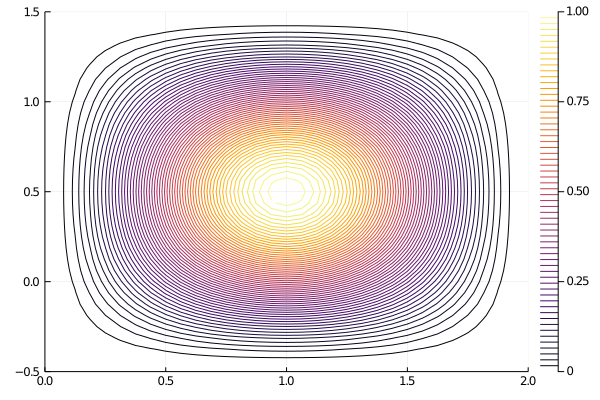

In [10]:
using Plots
gr()
contour(0:1/16:2, -0.5:1/16:1.5, (θ₁,θ₂) -> Ψ([0,π*θ₁,π*θ₂,0]), levels=60)

# Decomposing the Hamiltonian

For full VQE the Hamiltonian H needs to be decomposed into separate terms involving only Pauli matrices.

In [14]:
H

4×4 Array{Float64,2}:
 0.0  0.0  0.0  0.0
 0.0  0.5  0.5  0.0
 0.0  0.5  0.5  0.0
 0.0  0.0  0.0  0.0

In [15]:
X⊗X

4×4 Array{Int64,2}:
 0  0  0  1
 0  0  1  0
 0  1  0  0
 1  0  0  0

In [16]:
Y⊗Y

4×4 Array{Complex{Int64},2}:
  0+0im  0+0im  0+0im  -1+0im
  0+0im  0+0im  1+0im   0+0im
  0+0im  1+0im  0+0im   0+0im
 -1+0im  0+0im  0+0im   0+0im

In [17]:
Z⊗Z

4×4 Array{Int64,2}:
 1   0   0  0
 0  -1   0  0
 0   0  -1  0
 0   0   0  1

In [18]:
I₂⊗I₂+X⊗X+Y⊗Y-Z⊗Z

4×4 Array{Complex{Int64},2}:
 0+0im  0+0im  0+0im  0+0im
 0+0im  2+0im  2+0im  0+0im
 0+0im  2+0im  2+0im  0+0im
 0+0im  0+0im  0+0im  0+0im

In [19]:
# Check that the decomposition can be recombined into the original Hamiltonian
I₂⊗I₂+X⊗X+Y⊗Y-Z⊗Z ≈ 4H

true

### Another one

In [20]:
Q = [1  0  0 0; 
     0  0 -1 0;
     0 -1  0 0; 
     0  0  0 1]

4×4 Array{Int64,2}:
 1   0   0  0
 0   0  -1  0
 0  -1   0  0
 0   0   0  1

In [21]:
I₂⊗I₂-X⊗X-Y⊗Y+Z⊗Z ≈ 2Q

true

## Identity check

Check the following identity numerically:
$$
\langle \psi_1\otimes \psi_2 |U_1\otimes U_2|\psi_1\otimes \psi_2 \rangle = 
\langle \psi_1 |U_1|\psi_1 \rangle
\langle \psi_2 |U_2|\psi_2 \rangle
$$

In [17]:
U₁ = rand(8,8)
U₂ = rand(8,8)
ψ₁ = rand(8)
ψ₂ = rand(8)

(ψ₁'⊗ψ₂')*(U₁⊗U₂)*(ψ₁⊗ψ₂) ≈ (ψ₁'*U₁*ψ₁)*(ψ₂'*U₂*ψ₂)

true